In [151]:
# import package
from igraph import *
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, f1_score
from functools import reduce
import xgboost
import shap
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

----
# Step 1 Data Pre-processing
Process in-patient data, including creating labels

In [3]:
df_train_inp = pd.read_csv("Train_Inpatientdata-1542865627584.csv")
df_train_ben = pd.read_csv("Train_Beneficiarydata-1542865627584.csv")
df_train_fra = pd.read_csv("Train-1542865627584.csv")

In [4]:
print(df_train_inp.shape)
df_train_inp.head(2)

(40474, 30)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN


In [5]:
print(df_train_ben.shape)
df_train_ben.head(2)

(138556, 25)


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50


In [6]:
print(df_train_fra.shape)
df_train_fra.head(2)

(5410, 2)


,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes


Fraud (model target) is at provider level..

## 1) Prepare in patient data for modelling

In [7]:
df_train_inp['OperatingPhysician'].fillna('None', inplace=True)
df_train_inp['OtherPhysician'].fillna('None', inplace=True)

df_train_inp['ClaimStartDt'] = pd.to_datetime(df_train_inp['ClaimStartDt'], format = '%Y-%m-%d')
df_train_inp['ClaimEndDt'] = pd.to_datetime(df_train_inp['ClaimEndDt'], format = '%Y-%m-%d')

df_train_inp['ClaimDurationInDays'] = ((df_train_inp['ClaimEndDt']-df_train_inp['ClaimStartDt']).dt.days).astype('int64')

df_train_inp['AdmissionDt'] = pd.to_datetime(df_train_inp['AdmissionDt'], format='%Y-%m-%d')
df_train_inp['DischargeDt'] = pd.to_datetime(df_train_inp['DischargeDt'], format='%Y-%m-%d')
df_train_inp['AdmissionDurationInDays'] = ((df_train_inp['DischargeDt']-df_train_inp['AdmissionDt']).dt.days).astype('int64')
df_train_inp = df_train_inp.drop(columns=['ClaimEndDt', 'AdmissionDt', 'DischargeDt'])

# for ClmProcedureCodeCount in range(4):
#     df_train_inp['ClmProcedureCode_{}'.format(ClmProcedureCodeCount + 1)].fillna(0, inplace=True)
#
# for ClmDiagnosisCodeCount in range(10):
#     df_train_inp['ClmDiagnosisCode_{}'.format(ClmDiagnosisCodeCount + 1)].fillna('0', inplace=True)

diag_proce_col = ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_10',
                  'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                  'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
                  'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1',
                  'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
                  'ClmProcedureCode_5', 'ClmProcedureCode_6']
df_train_inp[diag_proce_col] = df_train_inp[diag_proce_col].replace({np.nan:0})

df_train_inp.DeductibleAmtPaid.fillna(0, inplace=True)

"""Encode categorical columns"""
def encoded_cat(dataset, feature_to_encode='', col_list=[]):
    """This function returns top 5 cat column useful in determining potential fraud"""
    outer_list = []
    for col in col_list:
        list_1 = list()

        for item in list(dataset[col]):
            if str(item) == str(feature_to_encode):
                list_1.append(1)
            else:
                list_1.append(0)

        outer_list.append(list_1)

    li_sum = np.array([0] * 40474)

    for i in range(0, len(outer_list)):
        li1 = np.array(outer_list[i])
        li_sum = li_sum + li1

    return li_sum


procedure_col = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
                 'ClmProcedureCode_5', 'ClmProcedureCode_6']

diagnosis_col = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
                 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']

#top 5 procedure
# 4019.0, 2724.0, 9904.0, 8154.0, 66.0
df_train_inp['pr_4019'] = encoded_cat(df_train_inp, '4019.0', procedure_col)
df_train_inp['pr_2724'] = encoded_cat(df_train_inp, '2724.0', procedure_col)
df_train_inp['pr_9904'] = encoded_cat(df_train_inp,'9904.0',procedure_col)
df_train_inp['pr_8154'] = encoded_cat(df_train_inp,'8154.0',procedure_col)
df_train_inp['pr_66'] = encoded_cat(df_train_inp,'66.0',procedure_col)

#top 5 diagnosis 
#4019,25000,2724,V5869,42731
df_train_inp['di_4019'] = encoded_cat(df_train_inp, '4019' ,diagnosis_col)
df_train_inp['di_25000'] = encoded_cat(df_train_inp, '25000' ,diagnosis_col)
df_train_inp['di_2724'] = encoded_cat(df_train_inp, '2724' ,diagnosis_col)
df_train_inp['di_V5869'] = encoded_cat(df_train_inp,'V5869',diagnosis_col)
df_train_inp['di_42731'] = encoded_cat(df_train_inp,'42731',diagnosis_col)

for i in diag_proce_col:
    df_train_inp[i][df_train_inp[i] != 0] = 1

df_train_inp[diag_proce_col] = df_train_inp[diag_proce_col].astype(float)

# adding column total_num_diag
df_train_inp['total_num_diag'] = 0
for col in diagnosis_col:
    df_train_inp['total_num_diag'] = df_train_inp['total_num_diag'] + df_train_inp[col]

# adding column total_num_proce
df_train_inp['total_num_proce'] = 0
for col in procedure_col:
    df_train_inp['total_num_proce'] = df_train_inp['total_num_proce'] + df_train_inp[col]

df_train_inp['total_num_diag'] = df_train_inp['total_num_diag'].astype(float)
df_train_inp['total_num_proce'] = df_train_inp['total_num_proce'].astype(float)

In [8]:
df_train_inp.head(2)

,BeneID,ClaimID,ClaimStartDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,...,pr_9904,pr_8154,pr_66,di_4019,di_25000,di_2724,di_V5869,di_42731,total_num_diag,total_num_proce
0,BENE11001,CLM46614,2009-04-12,PRV55912,26000,PHY390922,None,None,1.0,1068.0,...,0,0,0,1,0,1,0,0,9.0,0.0
1,BENE11001,CLM66048,2009-08-31,PRV55907,5000,PHY318495,PHY318495,None,1.0,1068.0,...,0,0,0,0,0,0,0,0,3.0,1.0


## 2) Pre-process benefit data

In [9]:
df_train_ben.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')

In [10]:
df_train_ben['ChronicCond_Diabetes'].value_counts()

1    83391
2    55165
Name: ChronicCond_Diabetes, dtype: int64

In [11]:
df_train_ben['ChronicCond_rheumatoidarthritis'].value_counts()

2    102972
1     35584
Name: ChronicCond_rheumatoidarthritis, dtype: int64

Columns contain value 1 or 2, need to be encoded

In [12]:
## One-hot encode the Columns
col_Chronic = [col for col in df_train_ben if col.startswith('ChronicCond_')]
df_train_ben_p = pd.get_dummies(df_train_ben, columns = col_Chronic)

## Assume value 1 in the original means the patient has chronical illness. Drop one-hot-encoded _2's
col_Chronic_2 = [col for col in df_train_ben_p if col.startswith('ChronicCond_') & col.endswith('_2')]
print(col_Chronic_2)
df_train_ben_p = df_train_ben_p.drop(columns=col_Chronic_2)

['ChronicCond_Alzheimer_2', 'ChronicCond_Heartfailure_2', 'ChronicCond_KidneyDisease_2', 'ChronicCond_Cancer_2', 'ChronicCond_ObstrPulmonary_2', 'ChronicCond_Depression_2', 'ChronicCond_Diabetes_2', 'ChronicCond_IschemicHeart_2', 'ChronicCond_Osteoporasis_2', 'ChronicCond_rheumatoidarthritis_2', 'ChronicCond_stroke_2']


In [13]:
df_train_ben_p['RenalDiseaseIndicator'].value_counts()

0    118978
Y     19578
Name: RenalDiseaseIndicator, dtype: int64

In [14]:
df_train_ben_p = pd.get_dummies(df_train_ben_p, columns = ['RenalDiseaseIndicator'])
df_train_ben_p = df_train_ben_p.drop(columns='RenalDiseaseIndicator_0')

In [15]:
df_train_ben_p.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt',
       'ChronicCond_Alzheimer_1', 'ChronicCond_Heartfailure_1',
       'ChronicCond_KidneyDisease_1', 'ChronicCond_Cancer_1',
       'ChronicCond_ObstrPulmonary_1', 'ChronicCond_Depression_1',
       'ChronicCond_Diabetes_1', 'ChronicCond_IschemicHeart_1',
       'ChronicCond_Osteoporasis_1', 'ChronicCond_rheumatoidarthritis_1',
       'ChronicCond_stroke_1', 'RenalDiseaseIndicator_Y'],
      dtype='object')

In [16]:
df_train_ben_p.head()

,BeneID,DOB,DOD,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,...,ChronicCond_KidneyDisease_1,ChronicCond_Cancer_1,ChronicCond_ObstrPulmonary_1,ChronicCond_Depression_1,ChronicCond_Diabetes_1,ChronicCond_IschemicHeart_1,ChronicCond_Osteoporasis_1,ChronicCond_rheumatoidarthritis_1,ChronicCond_stroke_1,RenalDiseaseIndicator_Y
0,BENE11001,1943-01-01,NaN,1,1,39,230,12,12,36000,...,1,0,0,1,1,1,0,1,1,0
1,BENE11002,1936-09-01,NaN,2,1,39,280,12,12,0,...,0,0,0,0,0,0,0,0,0,0
2,BENE11003,1936-08-01,NaN,1,1,52,590,12,12,0,...,0,0,0,0,0,1,0,0,0,0
3,BENE11004,1922-07-01,NaN,1,1,39,270,12,12,0,...,0,0,0,0,1,1,1,1,0,0
4,BENE11005,1935-09-01,NaN,1,1,24,680,12,12,0,...,0,0,1,0,1,0,0,0,0,0


## 3) Merge in-patient data with benefit data

In [17]:
## Merge inpatient data with benefits data
df_train_inp_m = pd.merge(df_train_inp, df_train_ben_p, on='BeneID', how='inner')

In [18]:
df_train_inp_m.head()

,BeneID,ClaimID,ClaimStartDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,...,ChronicCond_KidneyDisease_1,ChronicCond_Cancer_1,ChronicCond_ObstrPulmonary_1,ChronicCond_Depression_1,ChronicCond_Diabetes_1,ChronicCond_IschemicHeart_1,ChronicCond_Osteoporasis_1,ChronicCond_rheumatoidarthritis_1,ChronicCond_stroke_1,RenalDiseaseIndicator_Y
0,BENE11001,CLM46614,2009-04-12,PRV55912,26000,PHY390922,None,None,1.0,1068.0,...,1,0,0,1,1,1,0,1,1,0
1,BENE11001,CLM66048,2009-08-31,PRV55907,5000,PHY318495,PHY318495,None,1.0,1068.0,...,1,0,0,1,1,1,0,1,1,0
2,BENE11001,CLM68358,2009-09-17,PRV56046,5000,PHY372395,None,PHY324689,1.0,1068.0,...,1,0,0,1,1,1,0,1,1,0
3,BENE11011,CLM38412,2009-02-14,PRV52405,5000,PHY369659,PHY392961,PHY349768,1.0,1068.0,...,1,0,0,1,1,0,0,1,1,0
4,BENE11014,CLM63689,2009-08-13,PRV56614,10000,PHY379376,PHY398258,None,1.0,1068.0,...,1,0,1,1,0,1,0,0,0,1


## 4) Assign model label

Note fraud label is that provider level, not claim level

In [19]:
label_encoder = preprocessing.LabelEncoder()
df_train_fra['PotentialFraud'] = label_encoder.fit_transform(df_train_fra['PotentialFraud'])
df_train_inp_m = pd.merge(df_train_inp_m, df_train_fra, on='Provider', how='inner')

In [20]:
df_train_inp_m.head(2)

,BeneID,ClaimID,ClaimStartDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,...,ChronicCond_Cancer_1,ChronicCond_ObstrPulmonary_1,ChronicCond_Depression_1,ChronicCond_Diabetes_1,ChronicCond_IschemicHeart_1,ChronicCond_Osteoporasis_1,ChronicCond_rheumatoidarthritis_1,ChronicCond_stroke_1,RenalDiseaseIndicator_Y,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,PRV55912,26000,PHY390922,None,None,1.0,1068.0,...,0,0,1,1,1,0,1,1,0,1
1,BENE17521,CLM34721,2009-01-20,PRV55912,19000,PHY349293,PHY370861,PHY363291,1.0,1068.0,...,0,1,0,0,1,0,0,0,0,1


----
# Step 2 Build graph features
Process in-patient data, including creating labels

## 1) Create graph from dataframe:  BenefitID --> ClaimID

In [21]:
G1 = Graph.DataFrame(df_train_inp_m[['BeneID', 'ClaimID']], directed=False)

### Visualise the graph

In [22]:
# ## Visualise the graph
# out_fig_name = "G1.eps"

# visual_style = {}

# # Define colors used for outdegree visualization
# colours = ['#fecc5c', '#a31a1c']

# # Set bbox and margin
# visual_style["bbox"] = (3000,3000)
# visual_style["margin"] = 17

# # Set vertex colours
# visual_style["vertex_color"] = 'grey'

# # Set vertex size
# visual_style["vertex_size"] = 20

# # Set vertex lable size
# visual_style["vertex_label_size"] = 8

# # Don't curve the edges
# visual_style["edge_curved"] = False

# # Set the layout
# my_layout = G1.layout_fruchterman_reingold()
# visual_style["layout"] = my_layout

# # Plot the graph
# plot(G1, out_fig_name, **visual_style)

### Analyse the graph

In [90]:
## Analyse the graph
print("Number of vertices:", G1.vcount())
print("Number of edges:", G1.ecount())
print("Density of the graph:", 2*G1.ecount()/(G1.vcount()*(G1.vcount()-1)))

Number of vertices: 71763
Number of edges: 40474
Density of the graph: 1.5718496520735806e-05


In [91]:
degrees = []
total = 0

n_vertices = G1.vcount()

for n in range(n_vertices):
    neighbours = G1.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/n_vertices)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 1.1279907473210429
Maximum degree: 8
Vertex ID with the maximum degree: 7805


Degree having the maximum number of vertices: 1
Number of vertices having the most abundant degree: 64755


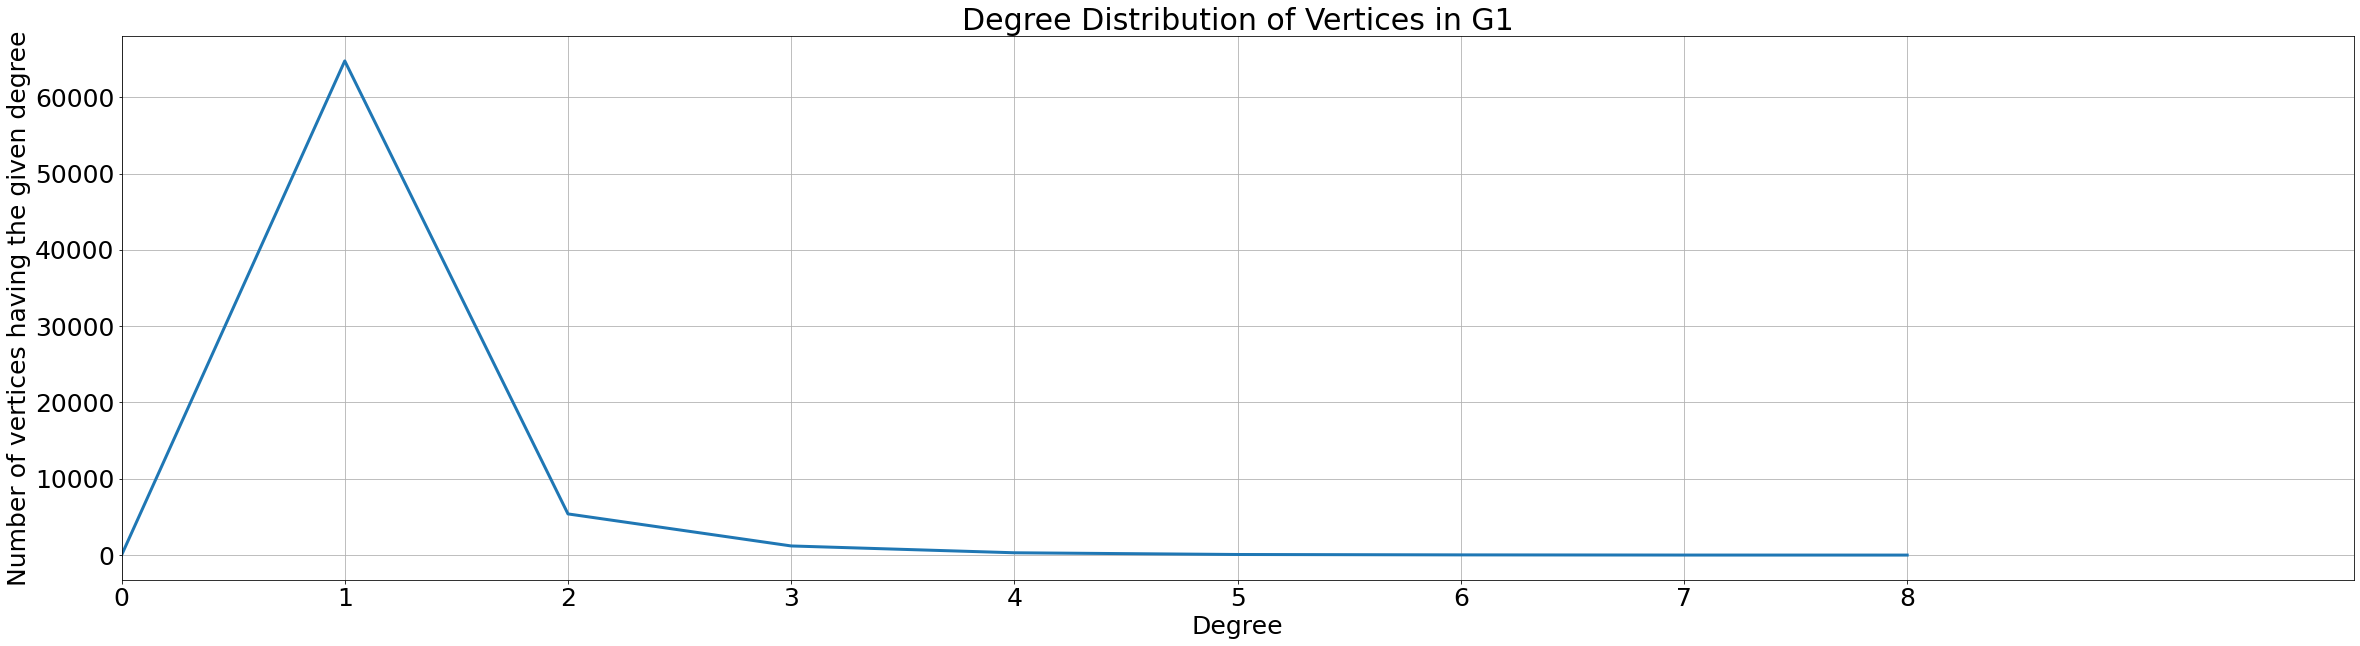

<Figure size 432x288 with 0 Axes>

In [92]:
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(9)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))

plt.figure(figsize=(40,10))
plt.plot(x, degree_counts, linewidth=3.0)
plt.ylabel('Number of vertices having the given degree')
plt.xlabel('Degree')
plt.title('Degree Distribution of Vertices in G1')

plt.xlim(0,10)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.grid(True)
plt.savefig('degree_distribution.png', bbox_inches='tight')
plt.show()
plt.draw()

In [93]:
cliques = G1.cliques(min=3, max=3)
triangle_count = [0] * G1.vcount()
for i, j, k in cliques:
    triangle_count[i] += 1
    triangle_count[j] += 1
    triangle_count[k] += 1

print("Average number of triangles:", sum(triangle_count)/G1.vcount())
print("Maximum number of triangles:", max(triangle_count))
print("Vertex ID with the maximum number of triangles:", triangle_count.index(max(triangle_count)))

Average number of triangles: 0.0
Maximum number of triangles: 0
Vertex ID with the maximum number of triangles: 0


In [87]:
print("Diameter of the graph:", G1.diameter())

Diameter of the graph: 2


In [88]:
def assortativity(graph, degrees=None):
    
    if degrees is None: degrees = graph.degree()
    degrees_sq = [deg**2 for deg in degrees]
 
    m = float(graph.ecount())
    num1, num2, den1 = 0, 0, 0
    for source, target in graph.get_edgelist():
        num1 += degrees[source] * degrees[target]
        num2 += degrees[source] + degrees[target]
        den1 += degrees_sq[source] + degrees_sq[target]
 
    num1 /= m
    den1 /= 2*m
    num2 = (num2 / (2*m)) ** 2
 
    return (num1 - num2) / (den1 - num2)

print("Assortativity of the graph:", assortativity(G1))

Assortativity of the graph: -0.17829490295257414


In [67]:
## Check a record
t1 = df_train_inp_m[df_train_inp_m['BeneID'] == 'BENE100075']
t1

,BeneID,ClaimID,ClaimStartDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,...,ChronicCond_Cancer_1,ChronicCond_ObstrPulmonary_1,ChronicCond_Depression_1,ChronicCond_Diabetes_1,ChronicCond_IschemicHeart_1,ChronicCond_Osteoporasis_1,ChronicCond_rheumatoidarthritis_1,ChronicCond_stroke_1,RenalDiseaseIndicator_Y,PotentialFraud
28039,BENE100075,CLM31820,2008-12-31,PRV52723,6000,PHY381381,PHY397516,None,1.0,1068.0,...,0,1,1,1,1,1,1,0,1,0
28476,BENE100075,CLM33847,2009-01-14,PRV52634,5000,PHY350551,None,None,1.0,1068.0,...,0,1,1,1,1,1,1,0,1,0
39829,BENE100075,CLM37126,2009-02-05,PRV52576,24000,PHY337457,PHY398470,None,1.0,1068.0,...,0,1,1,1,1,1,1,0,1,0


This patient had 3 claims with different providers, attending physician etc.

### To avoid model leakage, split the dataset into two time samples, and create two sets of graph features

In [91]:
## Split the data by claim date
df_train_inp_m_tr = df_train_inp_m[df_train_inp_m['ClaimStartDt'] < '2009-10-01'].drop('ClaimStartDt', axis=1)
print(df_train_inp_m0_tr.shape) 

df_train_inp_m_te = df_train_inp_m[df_train_inp_m['ClaimStartDt'] >= '2009-10-01'].drop('ClaimStartDt', axis=1)
print(df_train_inp_m_te.shape)

(31780, 52)
(8694, 65)


### Construct features

#### 1) Create graph from dataframe. BeneID -> ClaimID

In [ ]:
### Full graph
G1 = Graph.DataFrame(df_train_inp_m[['BeneID', 'ClaimID']], directed=False)

## degree
degree1 = pd.DataFrame({'Node': G1.vs["name"], 'g_degree_BeneID_ClaimID': G1.strength()})
## closeness
closeness1 = pd.DataFrame({'Node': G1.vs["name"], 'g_closeness_BeneID_ClaimID': G1.closeness()})
## infomap
communities_infomap1 = pd.DataFrame({'Node': G1.vs["name"], 'g_communities_infomap_BeneID_ClaimID': G1.community_infomap().membership})

In [81]:
### Graph only use training (earlier) data 
G1_tr = Graph.DataFrame(df_train_inp_m_tr[['BeneID', 'ClaimID']], directed=False)

## degree
degree1_tr = pd.DataFrame({'Node': G1_tr.vs["name"], 'g_degree_BeneID_ClaimID': G1_tr.strength()})
## closeness
closeness1_tr = pd.DataFrame({'Node': G1_tr.vs["name"], 'g_closeness_BeneID_ClaimID': G1_tr.closeness()})
## infomap
communities_infomap1_tr = pd.DataFrame({'Node': G1_tr.vs["name"], 'g_communities_infomap_BeneID_ClaimID': G1_tr.community_infomap().membership})

#### 2) Create graph from dataframe. Provider -> ClaimID

In [28]:
G2 = Graph.DataFrame(df_train_inp_m[['Provider', 'ClaimID']], directed=False)

## degree
degree2 = pd.DataFrame({'Node': G2.vs["name"], 'g_degree_Provider_ClaimID': G2.strength()})
## closeness
closeness2 = pd.DataFrame({'Node': G2.vs["name"], 'g_closeness_Provider_ClaimID': G2.closeness()})
## infomap
communities_infomap2 = pd.DataFrame({'Node': G2.vs["name"], 'g_communities_infomap_Provider_ClaimID': G2.community_infomap().membership})

In [84]:
### Graph only use training (earlier) data 
G2_tr = Graph.DataFrame(df_train_inp_m_tr[['Provider', 'ClaimID']], directed=False)

## degree
degree2_tr = pd.DataFrame({'Node': G2_tr.vs["name"], 'g_degree_Provider_ClaimID': G2_tr.strength()})
## closeness
closeness2_tr = pd.DataFrame({'Node': G2_tr.vs["name"], 'g_closeness_Provider_ClaimID': G2_tr.closeness()})
## infomap
communities_infomap2_tr = pd.DataFrame({'Node': G2_tr.vs["name"], 'g_communities_infomap_Provider_ClaimID': G2_tr.community_infomap().membership})

#### 3) Create graph from dataframe. Attending Physician  -> ClaimID

In [31]:
G3 = Graph.DataFrame(df_train_inp_m.loc[df_train_inp_m['AttendingPhysician'].notnull(),
                                        ['AttendingPhysician', 'ClaimID']], directed=False)

## degree
degree3 = pd.DataFrame({'Node': G3.vs["name"], 'g_degree_AttendingPhysician_ClaimID': G3.strength()})
## closenessZ
closeness3 = pd.DataFrame({'Node': G3.vs["name"], 'g_closeness__AttendingPhysician_ClaimID': G3.closeness()})
## infomap
communities_infomap3 = pd.DataFrame({'Node': G3.vs["name"], 'g_communities_infomap_AttendingPhysician_ClaimID': G3.community_infomap().membership})

In [85]:
### Graph only use training (earlier) data 
G3_tr = Graph.DataFrame(df_train_inp_m_tr.loc[df_train_inp_m_tr['AttendingPhysician'].notnull(),
                                              ['AttendingPhysician', 'ClaimID']], directed=False)

## degree
degree3_tr = pd.DataFrame({'Node': G3_tr.vs["name"], 'g_degree_AttendingPhysician_ClaimID': G3_tr.strength()})
## closeness
closeness3_tr = pd.DataFrame({'Node': G3_tr.vs["name"], 'g_closeness__AttendingPhysician_ClaimID': G3_tr.closeness()})
## infomap
communities_infomap3_tr = pd.DataFrame({'Node': G3_tr.vs["name"], 'g_communities_infomap_AttendingPhysician_ClaimID': G3_tr.community_infomap().membership})

#### 4) Create graph from dataframe. Provider --> Attending Physician

In [32]:
G4 = Graph.DataFrame(df_train_inp_m.loc[df_train_inp_m['AttendingPhysician'].notnull(),
                                        ['Provider', 'AttendingPhysician']], directed=False)

## degree
degree4 = pd.DataFrame({'Node': G4.vs["name"], 'g_degree_Provider_AttendingPhysician': G4.strength()})
## closeness
closeness4 = pd.DataFrame({'Node': G4.vs["name"], 'g_closeness_Provider_AttendingPhysician': G4.closeness()})
## infomap
communities_infomap4 = pd.DataFrame({'Node': G4.vs["name"], 'g_communities_infomap_Provider_AttendingPhysician': G4.community_infomap().membership})

In [87]:
### Graph only use training (earlier) data 
G4_tr = Graph.DataFrame(df_train_inp_m_tr.loc[df_train_inp_m_tr['AttendingPhysician'].notnull(),
                                              ['Provider', 'AttendingPhysician']], directed=False)

## degree
degree4_tr = pd.DataFrame({'Node': G4_tr.vs["name"], 'g_degree_Provider_AttendingPhysician': G4_tr.strength()})
## closeness
closeness4_tr = pd.DataFrame({'Node': G4_tr.vs["name"], 'g_closeness_Provider_AttendingPhysician': G4_tr.closeness()})
## infomap
communities_infomap4_tr = pd.DataFrame({'Node': G4_tr.vs["name"], 'g_communities_infomap_Provider_AttendingPhysician': G4_tr.community_infomap().membership})

#### 5) Create graph from dataframe. Provider --> BeneID

In [35]:
G5 = Graph.DataFrame(df_train_inp_m[['Provider', 'BeneID']], directed=False)

## degree
degree5 = pd.DataFrame({'Node': G5.vs["name"], 'g_degree_Provider_BeneID': G5.strength()})
## closeness
closeness5 = pd.DataFrame({'Node': G5.vs["name"], 'g_closeness_Provider_BeneID': G5.closeness()})
## infomap
communities_infomap5 = pd.DataFrame({'Node': G5.vs["name"], 'g_communities_infomap_Provider_BeneID': G5.community_infomap().membership})

In [88]:
### Graph only use training (earlier) data 
G5_tr = Graph.DataFrame(df_train_inp_m_tr[['Provider', 'BeneID']], directed=False)

## degree
degree5_tr = pd.DataFrame({'Node': G5_tr.vs["name"], 'g_degree_Provider_BeneID': G5_tr.strength()})
## closeness
closeness5_tr = pd.DataFrame({'Node': G5_tr.vs["name"], 'g_closeness_Provider_BeneID': G5_tr.closeness()})
## infomap
communities_infomap5_tr = pd.DataFrame({'Node': G5_tr.vs["name"], 'g_communities_infomap_Provider_BeneID': G5_tr.community_infomap().membership})

#### 6) Create graph from dataframe. Provider --> DiagnosisGroupCode

In [72]:
G6 = Graph.DataFrame(df_train_inp_m[['Provider', 'DiagnosisGroupCode']], directed=False)

## degree
degree6 = pd.DataFrame({'Node': G6.vs["name"], 'g_degree_Provider_DiagnosisGroupCode': G6.strength()})
## closeness
closeness6 = pd.DataFrame({'Node': G6.vs["name"], 'g_closeness_Provider_DiagnosisGroupCode': G6.closeness()})
## infomap
communities_infomap6 = pd.DataFrame({'Node': G6.vs["name"], 'g_communities_infomap_Provider_DiagnosisGroupCode': G6.community_infomap().membership})

In [90]:
### Graph only use training (earlier) data 
G6_tr = Graph.DataFrame(df_train_inp_m_tr[['Provider', 'DiagnosisGroupCode']], directed=False)

## degree
degree6_tr = pd.DataFrame({'Node': G6_tr.vs["name"], 'g_degree_Provider_DiagnosisGroupCode': G6_tr.strength()})
## closeness
closeness6_tr = pd.DataFrame({'Node': G6_tr.vs["name"], 'g_closeness_Provider_DiagnosisGroupCode': G6_tr.closeness()})
## infomap
communities_infomap6_tr = pd.DataFrame({'Node': G6_tr.vs["name"], 'g_communities_infomap_Provider_DiagnosisGroupCode': G6_tr.community_infomap().membership})

## Merge all graph features

- Provider- ClaimID relationship (G2), 
- Provider- Attending Physician relationship (G4), 
- Provider- BeneID relationship (G5), 
- Provider- DiagnosisGroupCode relationship (G6)

In [122]:
## Graph feature generated from training (earlier) data
graph_feature_tr = [degree2_tr, closeness2_tr, communities_infomap2_tr,
                    degree4_tr, closeness4_tr, communities_infomap4_tr,
                    degree5_tr, closeness5_tr, communities_infomap5_tr,
                    degree6_tr, closeness6_tr, communities_infomap6_tr]
graph_feature_tr = reduce(lambda left, right: pd.merge(left, right, how='left', on='Node'), graph_feature_tr)
graph_feature_tr = graph_feature_tr[graph_feature_tr['Node'].str.contains('PRV')].set_index('Node')
print(graph_feature_tr.shape)

(2041, 12)


In [123]:
## Graph feature generated from full dataset for test
graph_feature_te = [degree2, closeness2, communities_infomap2,
                    degree4, closeness4, communities_infomap4,
                    degree5, closeness5, communities_infomap5,
                    degree6, closeness6, communities_infomap6]
graph_feature_te = reduce(lambda left, right: pd.merge(left, right, how='left', on='Node'), graph_feature_te)
graph_feature_te = graph_feature_te[graph_feature_te['Node'].str.contains('PRV')].set_index('Node')
print(graph_feature_te.shape)

(2092, 12)


----
# Step 3 Train Models

The aim of the model is to predict provider level fraud.<br>
Data will need to be aggregated to a provider level first. <br>
Then append graph features at ProviderID level. At this stage, discard graph features that is not at ProviderID level.

### 1) Aggregate model base to ProviderID level

In [93]:
df_train_inp_m_tr.columns

Index(['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'ClaimDurationInDays', 'AdmissionDurationInDays',
       'pr_4019', 'pr_2724', 'pr_9904', 'pr_8154', 'pr_66', 'di_4019',
       'di_25000', 'di_2724', 'di_V5869', 'di_42731', 'total_num_diag',
       'total_num_proce', 'DOB', 'DOD', 'Gender', 'Race', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAn

In [96]:
## Remove some categorical columns such as age, race etc
df_train_inp_m0_tr = df_train_inp_m_tr.drop(['BeneID', 'ClaimID', 'AttendingPhysician', 'OperatingPhysician',
                                             'OtherPhysician', 'ClmAdmitDiagnosisCode', 'DOB', 'DOD', 'Gender',
                                             'Race', 'State', 'County', 'DiagnosisGroupCode'], axis=1)

df_train_inp_m1_tr = df_train_inp_m0_tr.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
df_train_inp_m1_tr = df_train_inp_m1_tr.set_index('Provider')
print(df_train_inp_m1_tr.shape)

(2041, 51)


In [97]:
## Remove some categorical columns such as age, race etc
df_train_inp_m0_te = df_train_inp_m_te.drop(['BeneID', 'ClaimID', 'AttendingPhysician', 'OperatingPhysician',
                                             'OtherPhysician', 'ClmAdmitDiagnosisCode', 'DOB', 'DOD', 'Gender',
                                             'Race', 'State', 'County', 'DiagnosisGroupCode'], axis=1)

df_train_inp_m1_te = df_train_inp_m0_te.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
df_train_inp_m1_te = df_train_inp_m1_te.set_index('Provider')
print(df_train_inp_m1_te.shape)

(1544, 51)


In [98]:
df_train_inp_m1_te.head(2)

,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,...,ChronicCond_KidneyDisease_1,ChronicCond_Cancer_1,ChronicCond_ObstrPulmonary_1,ChronicCond_Depression_1,ChronicCond_Diabetes_1,ChronicCond_IschemicHeart_1,ChronicCond_Osteoporasis_1,ChronicCond_rheumatoidarthritis_1,ChronicCond_stroke_1,RenalDiseaseIndicator_Y
Provider,,,,,,,,,,,,,,,,,,,,,
PRV51003,1,103000,11748.0,11.0,11.0,10.0,10.0,10.0,9.0,9.0,...,5,0,4,2,7,10,3,2,1,2
PRV51011,0,5000,1068.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,1,1,1,1,1,0,1


In [100]:
df_train_inp_m1_tr['PotentialFraud'].value_counts()

0    1601
1     440
Name: PotentialFraud, dtype: int64

In [101]:
df_train_inp_m1_te['PotentialFraud'].value_counts()

0    1137
1     407
Name: PotentialFraud, dtype: int64

Good, model target looks good.

### 2) Append graph features

In [128]:
print(df_train_inp_m1_tr.shape)
df_train_inp_m_tr_g = df_train_inp_m1_tr.join(graph_feature_tr, how='inner')
print(df_train_inp_m_tr_g.shape)

(2041, 51)
(2041, 63)


In [127]:
print(df_train_inp_m1_te.shape)
df_train_inp_m_te_g = df_train_inp_m1_te.join(graph_feature_te, how='inner')
print(df_train_inp_m_te_g.shape)

(1544, 51)
(1544, 63)


### 3) Set up a seperate model base without the graph features

In [129]:
df_train_inp_m_tr_ng = df_train_inp_m1_tr.copy()
df_train_inp_m_tr_ng = df_train_inp_m_tr_ng.drop(procedure_col, axis=1)
df_train_inp_m_tr_ng = df_train_inp_m_tr_ng.drop(diagnosis_col, axis=1)
print(df_train_inp_m_tr_ng.shape)
print(df_train_inp_m_tr_ng.columns)

(2041, 35)
Index(['PotentialFraud', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'ClaimDurationInDays', 'AdmissionDurationInDays', 'pr_4019', 'pr_2724',
       'pr_9904', 'pr_8154', 'pr_66', 'di_4019', 'di_25000', 'di_2724',
       'di_V5869', 'di_42731', 'total_num_diag', 'total_num_proce',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt',
       'ChronicCond_Alzheimer_1', 'ChronicCond_Heartfailure_1',
       'ChronicCond_KidneyDisease_1', 'ChronicCond_Cancer_1',
       'ChronicCond_ObstrPulmonary_1', 'ChronicCond_Depression_1',
       'ChronicCond_Diabetes_1', 'ChronicCond_IschemicHeart_1',
       'ChronicCond_Osteoporasis_1', 'ChronicCond_rheumatoidarthritis_1',
       'ChronicCond_stroke_1', 'RenalDiseaseIndicator_Y'],
      dtype='object')


In [130]:
df_train_inp_m_te_ng = df_train_inp_m1_te.copy()
df_train_inp_m_te_ng = df_train_inp_m_te_ng.drop(procedure_col, axis=1)
df_train_inp_m_te_ng = df_train_inp_m_te_ng.drop(diagnosis_col, axis=1)
print(df_train_inp_m_te_ng.shape)

(1544, 35)


### 4) Train models

In [147]:
## Set up two model training sets, one with graph features, one without graph features
x_train_g = df_train_inp_m_tr_g.drop(axis=1, columns=['PotentialFraud'])
x_train_ng = df_train_inp_m_tr_ng.drop(axis=1, columns=['PotentialFraud'])
y_train = df_train_inp_m_tr_g['PotentialFraud']

x_test_g = df_train_inp_m_te_g.drop(axis=1, columns=['PotentialFraud'])
x_test_ng = df_train_inp_m_te_ng.drop(axis=1, columns=['PotentialFraud'])
y_test = df_train_inp_m_te_g['PotentialFraud']

### Experiment 1: Train GBM model with and **WITHOUT** graph features

In [154]:
## fit model without graph features
xgb_model_ng = xgboost.sklearn.XGBRegressor(eval_metric='auc',
                                           objective='binary:logistic',
                                           learning_rate=0.2,
                                           n_estimators=10,
                                           scale_pos_weight=1,
                                           gamma=0.5,
                                           min_child_weight=3,
                                           subsample=0.9,
                                           colsample_bytree=0.9,
                                           max_depth=2)
xgb_model_ng.fit(x_train_ng, y_train, verbose=True)

y_pred_ng = xgb_model_ng.predict(x_test_ng)
auc_ng = roc_auc_score(y_test, y_pred_ng)
gini_ng = 2 * auc_ng- 1
print("Test gini without graph feature is: ", gini_ng.round(4))
print("Test AUC without graph feature is: ", auc_ng.round(4))

explainer_ng = shap.TreeExplainer(xgb_model_ng)
shap_ng = explainer_ng.shap_values(x_train_ng)
shap_ng = pd.DataFrame(shap_ng)
shap_ng.columns = x_train_ng.columns
df_shap_ng = pd.DataFrame(shap_ng.sum(axis=0, skipna=True).abs()).sort_values(by=[0], ascending=False)
df_shap_ng.columns = ["shap_value"]
print()
print("Top 10 features by shapley value for model without graph features are: \n", df_shap_ng.head(10))

Test gini without graph feature is:  0.533
Test AUC without graph feature is:  0.7665

Top 10 features by shapley value for model without graph features are: 
                              shap_value
InscClaimAmtReimbursed       194.588608
di_2724                       45.241909
di_25000                      33.343601
OPAnnualReimbursementAmt      31.918221
ClaimDurationInDays           27.247557
OPAnnualDeductibleAmt          7.619026
AdmissionDurationInDays        2.910347
IPAnnualReimbursementAmt       1.925600
ChronicCond_Diabetes_1         0.000000
ChronicCond_IschemicHeart_1    0.000000


### Experiment 2: Train GBM model with and **WITH** graph features

In [156]:
## fit model with graph features
xgb_model_g = xgboost.sklearn.XGBRegressor(eval_metric='auc',
                                           objective='binary:logistic',
                                           learning_rate=0.2,
                                           n_estimators=10,
                                           scale_pos_weight=1,
                                           gamma=0.5,
                                           min_child_weight=3,
                                           subsample=0.9,
                                           colsample_bytree=0.9,
                                           max_depth=2)
xgb_model_g.fit(x_train_g, y_train, verbose=True)

y_pred_g = xgb_model_g.predict(x_test_g)
auc_g = roc_auc_score(y_test, y_pred_g)
gini_g = 2 * auc_g - 1
print("Test gini with graph feature is: ", gini_g.round(4))
print("Test AUC with graph feature is: ", auc_g.round(4))

explainer_g = shap.TreeExplainer(xgb_model_g)
shap_g = explainer_g.shap_values(x_train_g)
shap_g = pd.DataFrame(shap_g)
shap_g.columns = x_train_g.columns
df_shap_g = pd.DataFrame(shap_g.sum(axis=0, skipna=True).abs()).sort_values(by=[0], ascending=False)
df_shap_g.columns = ["shap_value"]
print()
print("Top 10 features by shapley value for model with graph features are: \n", df_shap_g.head(10))

Test gini with graph feature is:  0.5288
Test AUC with graph feature is:  0.7644

Top 10 features by shapley value for model with graph features are: 
                                          shap_value
InscClaimAmtReimbursed                   183.947800
di_2724                                   43.214848
ClaimDurationInDays                       35.168591
AdmissionDurationInDays                   33.144417
OPAnnualReimbursementAmt                  26.263226
OPAnnualDeductibleAmt                      9.073974
g_closeness_Provider_DiagnosisGroupCode    7.813434
ClmDiagnosisCode_8                         2.385093
ChronicCond_Alzheimer_1                    0.000000
IPAnnualDeductibleAmt                      0.000000
